In [1]:
import os
os.chdir(os.pardir)

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import matplotlib.patches as mpatches
import pandas as pd

import vapor
from vapor.models import Cambium

2020-10-30 12:46:27,540 [MainThread  ] [INFO ]  Starting log for vapor...


In [2]:
dfs = []

# --- Define Optimization Variables ---
aggregate_region = 'state'
opt_vars = ['adjusted_installed_cost']
scenarios = ['StdScen19_Mid_Case']
techs = ['wind','pv']
constraints = ['hourly_energy','annual_recs']
constraint_pcts = [25,50,75,95]

for opt_var in opt_vars:
    for scenario in scenarios:
        for tech in techs:
            for constraint in constraints:
                for constraint_pct in constraint_pcts:
                    file = f"{aggregate_region}_best_{tech}_{scenario}_{opt_var}_constraint_{constraint}_{constraint_pct}.pkl"
                    fp = os.path.join('results',file)
                    df = pd.read_pickle(fp)
                    df['goal_type'] = constraint
                    df['goal_pct'] = constraint_pct
                    dfs.append(df)


results = pd.concat(dfs, axis='rows')

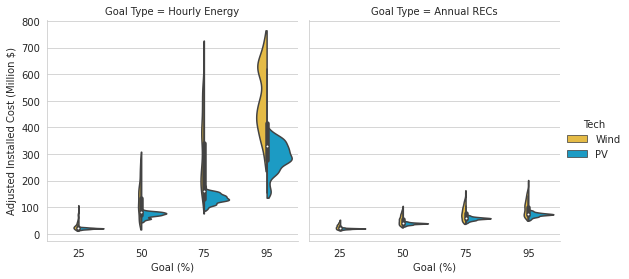

In [3]:
import seaborn as sns
sns.set_style('whitegrid')

data = results[['region','tech','goal_type','goal_pct', 'adjusted_installed_cost']]
data['adjusted_installed_cost'] /= 1000000
data = data.loc[~data['region'].isin(['CA','UT','AZ'])]
data = data.loc[data['adjusted_installed_cost'] < 750]

rename_dict = {'hourly_energy':'Hourly Energy', 'annual_recs':'Annual RECs'}
data['goal_type'] = data['goal_type'].map(rename_dict)
data.columns = ['region','Tech','Goal Type', 'goal_pct','adjusted_installed_cost']
tech_dict = {'pv':'PV', 'wind':'Wind'}
data['Tech'] = data['Tech'].map(tech_dict)

sns.set_palette(sns.color_palette([vapor.tech_dict['pv'], vapor.tech_dict['wind']]))

g = sns.catplot(x='goal_pct', y='adjusted_installed_cost',
                hue='Tech', col='Goal Type',
               data=data, kind='violin', split=True, bw=.3,
               height=4, aspect=1, cut=True)

g.set_xlabels('Goal (%)')
g.set_ylabels('Adjusted Installed Cost (Million $)')

In [4]:
grouped = results.groupby(['tech','goal_type','goal_pct'], as_index=False)\
                [['adjusted_installed_cost','annual_energy','marginal_cost_mwh','lifetime_co2_rate_avg',]].mean()
grouped.sort_values(['tech','goal_type','goal_pct'], inplace=True)
grouped[['adjusted_installed_cost','annual_energy','lifetime_co2_rate_avg']] /= 1e6

rename_dict = {'hourly_energy':'Hourly Energy', 'annual_recs':'Annual RECs'}
grouped['goal_type'] = grouped['goal_type'].map(rename_dict)
tech_dict = {'pv':'PV', 'wind':'Wind'}
grouped['tech'] = grouped['tech'].map(tech_dict)

grouped.columns = ['Tech', 'Goal Type', 'Goal %', 'Adjusted Installed Cost (mill. $)','Annual Energy Production (GWh)','Marginal Cost ($/MWh)', 'Lifetime Avoided CO2 (mill. lbs)']
grouped.to_csv(os.path.join('images','constraint_table.csv'))
grouped


KeyError: "Columns not found: 'lifetime_co2_rate_avg'"

In [ ]:
system_configs = results[['region','tech','goal_type','goal_pct','adjusted_installed_cost',
                         'system_capacity',
                          'turbine_class','wind_turbine_hub_ht',
                          'subarray1_azimuth','subarray1_tilt',
                          'dc_ac_ratio',
                          'desired_power','desired_capacity']]
system_configs['batt_duration'] = system_configs['desired_capacity'] / system_configs['desired_power']

states = system_configs.copy()
states = states.loc[states['region'].isin(['CA','NY','TX'])]
states = states.loc[states['goal_type'] == 'hourly_energy']
states.sort_values(['region','goal_pct','adjusted_installed_cost'], inplace=True, ascending=True)
states.drop_duplicates(subset=['region','goal_pct'], inplace=True)

states['adjusted_installed_cost'] /= 1e6
states[['system_capacity','desired_capacity']] /= 1e3
states.to_csv(os.path.join('images','best_systems_table.csv'))
states

In [ ]:
list(results.columns)